# Import Library

In [1]:
import warnings
from sklearn.metrics import average_precision_score
import nltk
import pandas as pd
from keras import optimizers
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing.text import text_to_word_sequence
from nltk import tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm
import os
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model
from keras import backend as K
import re
from nltk.corpus import stopwords
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints
from keras.preprocessing.sequence import pad_sequences
import keras.backend
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt
import itertools

Using TensorFlow backend.
c:\venv_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\venv_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\venv_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\venv_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a s

In [2]:
# set up GPU to run model if your server have many gpus. This code below, We config use GPU 5. you can modify it 0, 1, 2,...
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Set up mode to run model

In [3]:
model_mode = 'test' # 'train' if you wanna train model else 'test' to run testing without train

Find current path and download 'punkt'

In [4]:
current_path = os.getcwd()
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Set up necessary hyperparameters

In [5]:
# -----------hyper-parameters of HAN_LSTM-------------------
threshold_LSTM = 0.95
# -----------hyper-parameters of HAN_LSTM-------------------

# -----------hyper-parameters of DNN------------------------
DNN_UNITS = 100
DNN_LEARNING_RATE = 0.001
DNN_EPOCHS = 200
DNN_BATCH_SIZE = 64
threshold_DNN = 0.3
# -----------hyper-parameters of DNN------------------------

# -----------hyper-parameters of CNN------------------------
CNN_filters = 6
CNN_FULLY_CONNECTED_UNITS = 100
CNN_LEARNING_RATE = 0.001
CNN_EPOCHS = 200
CNN_BATCH_SIZE = 64
threshold_CNN = 0.5
# -----------hyper-parameters of CNN------------------------

# embedding hyperparameter
max_features = 70000
max_senten_len = 32
max_senten_num = 4
embed_size = 100
# embedding hyperparameter
target_names = ['class 0', 'class 1']

# Read data from hard disk

In [6]:
# -----------read data--------------------------------------
Product_Behavioral_Features = pd.read_excel('./data/Resulting Features_Product_Centric_Behavioral_Features.xlsx')
Product_Textual_Features = pd.read_excel('./data/Resulting_Features_Product_Centric_Textual_Features.xlsx')
Review_Behavioral_Features = pd.read_excel('./data/Review_Centric_Behavioral_Features.xlsx')
Review_Textual_Features = pd.read_excel('./data/Review_Centric_Textual_Features.xlsx')
Reviewer_Textual_Features = pd.read_excel('./data/Reviewer_Centric_Textual_Features.xlsx')
Reviewer_Behavioral_Features = pd.read_excel('./data/Reviewer_Centric_Behavioral_Features.xlsx')
product_feature = Product_Behavioral_Features.join(Product_Textual_Features, how='outer')
reviewer_feature = Reviewer_Behavioral_Features.join(Reviewer_Textual_Features, how='outer')
review_feature = Review_Behavioral_Features.join(Review_Textual_Features, how='outer')

Labels_for_products = pd.read_excel("./data/Labels_for_products.xlsx")
Labels_for_reviewers = pd.read_excel("./data/Labels_for_reviewers.xlsx")
Labels_for_reviews = pd.read_excel("./data/Labels_for_reviews.xlsx")
Metadata_Sortedby_Product_wise = pd.read_excel("./data/Metadata (Sortedby_Product_wise).xlsx")
Metadata_Sortedby_Reviewer_wise = pd.read_excel("./data/Metadata (Sortedby_Reviewer_wise).xlsx")
ReviewContent_Sortedby_Product_wise = pd.read_excel("./data/ReviewContent (Sortedby_Product_wise).xlsx")
ReviewContent_Sortedby_Reviewer_wise = pd.read_excel("./data/ReviewContent (Sortedby_Reviewer_wise).xlsx")
Labels_for_reviews.rename(
    columns={'Reviewer_id': 'Reviewer_id_from_Labels_for_reviews', 'Label': 'Label_Labels_for_reviews'}, inplace=True)
ReviewContent_Sortedby_Product_wise.rename(
    columns={'Reviewer_id': 'Reviewer_id_from_ReviewContent_Sortedby_Product_wise',
             'Product_id': 'Product_id_from_ReviewContent_Sortedby_Product_wise',
             'Date': 'Date_from_ReviewContent_Sortedby_Product_wise',
             'Text': 'Text_from_ReviewContent_Sortedby_Product_wise'}, inplace=True)
Metadata_Sortedby_Product_wise.rename(columns={'Reviewer_id': 'Reviewer_id_fromMeta_sortby_productwise',
                                               'Product_id': 'Product_id_fromMeta_sortby_productwise',
                                               'Label': 'Label_from_meta_product_wise',
                                               'Rating': 'Rating_fromMeta_sortby_productwise',
                                               'Date': 'Date_fromMeta_sortby_productwise'}, inplace=True)
#
review_feature_with_data = review_feature.join(ReviewContent_Sortedby_Product_wise[
                                                   ['Reviewer_id_from_ReviewContent_Sortedby_Product_wise',
                                                    'Product_id_from_ReviewContent_Sortedby_Product_wise',
                                                    'Date_from_ReviewContent_Sortedby_Product_wise',
                                                    'Text_from_ReviewContent_Sortedby_Product_wise']], how='outer')
review_feature_with_data = review_feature_with_data.join(Metadata_Sortedby_Product_wise, how='outer')
review_feature_with_data = review_feature_with_data.join(Labels_for_reviews, how='outer')

product_final = product_feature.join(Labels_for_products)
review_final = review_feature.join(Labels_for_reviews)
reviewer_final = reviewer_feature.join(Labels_for_reviewers)

feature_with_id = review_feature_with_data
reviewr_id_transform = reviewer_final
product_id_transform = product_final

reviewr_id_transform = reviewr_id_transform.rename(columns={'Reviewer_id': 'Reviewer_id_from_Labels_for_reviews'})
product_id_transform = product_id_transform.rename(columns={'Product_id': 'Product_id_fromMeta_sortby_productwise'})

feature_with_reviewr = pd.merge(feature_with_id, reviewr_id_transform, on=['Reviewer_id_from_Labels_for_reviews'],
                                how='left')
feature_with_reviewr2 = feature_with_reviewr.add_suffix("_r")
product_id_transform2 = product_id_transform.add_suffix("_p")
multi_view_features = pd.merge(feature_with_reviewr2, product_id_transform2,
                               left_on='Product_id_fromMeta_sortby_productwise_r',
                               right_on='Product_id_fromMeta_sortby_productwise_p',
                               how='left').replace(to_replace={-1: 0, 1: 1})

data = review_feature_with_data

data['Text_from_ReviewContent_Sortedby_Product_wise'].replace(to_replace={np.nan: ""}, inplace=True)
new_data = data[['Text_from_ReviewContent_Sortedby_Product_wise', 'Label_Labels_for_reviews']].rename(
    columns={'Text_from_ReviewContent_Sortedby_Product_wise': "text", 'Label_Labels_for_reviews': "category"})
new_data = new_data.replace(to_replace={-1: 0, 1: 1})
df = new_data.reset_index(drop=True)
categories = df['category']
text = df['text']

# Some functions and variable to remove redundant character.

In [7]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#',
          '*', '+', '\\', '•', '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â',
          '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―',
          '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸',
          '¾', 'Ã', '⋅', '‘', '∞',
          '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
          '¹', '≤', '‡', '√', ]


def clean_data(text):
    """
        text: a string

        return: modified initial string
    """
    #     text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = str(text).lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x


def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = str(string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    string = clean_text(string)
    string = clean_numbers(string)
    string = clean_data(string)
    return string.strip().lower()

# Tokenize word or you can use keras API

In [8]:
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

tokenizer = Tokenizer(num_words=max_features, oov_token=True, lower=True,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      split=' ', char_level=False)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j < max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    if k < max_senten_len and tokenizer.word_index[word] < max_features:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                except:
                    print(word)
                    pass

word_index = tokenizer.word_index

# Prepare data for Input into keras.models.Model()

In [9]:
labels = categories

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
VALIDATION_SPLIT = 0.1
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  train_size=0.8, test_size=0.1,
                                                  stratify=y_train)
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]

product_feature_s = product_feature.add_suffix("_p")
x_product = product_feature_s.values
y_product = Labels_for_products.Label.replace(to_replace={-1: 0}).values
X_train_product, X_test_product, y_train_product, y_test_product = train_test_split(x_product, y_product,
                                                                                    train_size=0.8, test_size=0.1,
                                                                                    stratify=y_product)
X_train_product, X_val_product, y_train_product, y_val_product = train_test_split(X_train_product, y_train_product,
                                                                                  train_size=0.8, test_size=0.1,
                                                                                  stratify=y_train_product)
reviewer_feature_s = reviewer_feature.add_suffix("_r")

x_reviewer = reviewer_feature_s.values
y_reviewer = Labels_for_reviewers.Label.replace(to_replace={-1: 0}).values
X_train_reviewer, X_test_reviewer, y_train_reviewer, y_test_reviewer = train_test_split(x_reviewer, y_reviewer,
                                                                                        train_size=0.8, test_size=0.1,
                                                                                        stratify=y_reviewer)
X_train_reviewer, X_val_reviewer, y_train_reviewer, y_val_reviewer = train_test_split(X_train_reviewer,
                                                                                      y_train_reviewer,
                                                                                      train_size=0.8, test_size=0.1,
                                                                                      stratify=y_train_reviewer)
X_train_reviewer = X_train_reviewer.reshape(len(X_train_reviewer), X_train_reviewer.shape[1], 1)
X_train_reviewer = X_train_reviewer.reshape(len(X_train_reviewer), X_train_reviewer.shape[1], 1)
X_test_reviewer = X_test_reviewer.reshape(len(X_test_reviewer), X_test_reviewer.shape[1], 1)
X_val_reviewer = X_val_reviewer.reshape(len(X_val_reviewer), X_val_reviewer.shape[1], 1)

# maybe you can use l1, l2, ..., ln to avoid overfit 

In [10]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(0.01)

# Get matrix embedding from global vector. you can download and use others.

In [11]:
GLOVE_DIR = "./data/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        pass
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1

Here's the balance function for imbalance data. you can use or not. In my opinion, It can be good for model.

In [12]:
# HAN using LSTM here
def balance(x_train, y_train, n, mode=None):
    x_train_neg = x_train[y_train == 0]
    y_train_neg = y_train[y_train == 0]
    x_train_pos = x_train[y_train == 1]
    y_train_pos = y_train[y_train == 1]
    if mode == 'DNN':
        x_train_pos = np.tile(x_train_pos, (n, 1))
        y_train_pos = np.tile(y_train_pos, n)
        x_train = np.concatenate((x_train_pos, x_train_neg), axis=0)
        y_train = np.concatenate((y_train_pos, y_train_neg), axis=0)
        return x_train, y_train
    x_train_neg = np.tile(x_train_neg, (n, 1, 1))
    y_train_neg = np.tile(y_train_neg, n)
    x_train = np.concatenate((x_train_pos, x_train_neg), axis=0)
    y_train = np.concatenate((y_train_pos, y_train_neg), axis=0)
    return x_train, y_train

You can remove some stopword. maybe, use it or not

In [13]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Below is some function to show result

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

Function for clean string before

In [15]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = str(string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    string = clean_text(string)
    string = clean_numbers(string)
    string = clean_data(string)
    return string.strip().lower()

Here is HAN model. it contain the data and model.
2 things you need to focus.
1. Tensorboad: it mean the API can log history of training process to be able to choose the best epoch( the best model)
  - open tensorboard by openning the command prompt and run command: tensorboard --logdir=path to HAN folder
2. Model checkpoint: It will save the papameters after every epochs.
In HAN, it will save at HAN folder

In [16]:
def HAN(df, mode='train'):
    df.head()
    df1 = df.sample(frac=1)
    df1.head()
    label_encoder = preprocessing.LabelEncoder()
    df1['category'] = label_encoder.fit_transform(df1['category'])

    df1['category'].unique()
    df1.head()
    df1.describe()
    X = df1.text
    y = df1.category

    df1.head()

    def clean_data(text):
        """
            text: a string

            return: modified initial string
        """
        text = str(text).lower().split()
        text = " ".join(text)
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", " - ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)

        return text

    df1['text'] = df1['text'].apply(clean_data)
    X = df1.text
    y = df1.category
    X = X.map(lambda a: clean_data(a))
    train, test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    tokenizer = Tokenizer(num_words=None, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ',
                          char_level=False)

    tokenizer.fit_on_texts(X)
    x_train = tokenizer.texts_to_sequences(train)
    x_test = tokenizer.texts_to_sequences(test)
    word_index = tokenizer.word_index
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(word_index)
    print('Vocab size: {}'.format(vocab_size))
    longest = max(len(seq) for seq in X)
    print("Longest comment size: {}".format(longest))
    average = np.mean([len(seq) for seq in X])
    print("Average comment size: {}".format(average))
    stdev = np.std([len(seq) for seq in X])
    print("Stdev of comment size: {}".format(stdev))
    max_len = int(average + stdev * 3)
    print('Max comment size: {}'.format(max_len))

    def balance(x_train, y_train, n):
        x_train = np.array(x_train)
        x_train_neg = x_train[y_train == 0]
        y_train_neg = y_train[y_train == 0]
        x_train_pos = x_train[y_train == 1]
        y_train_pos = y_train[y_train == 1]
        x_train_neg = np.tile(x_train_neg, (n, 1))
        y_train_neg = np.tile(y_train_neg, n)
        x_train = np.concatenate((x_train_pos, x_train_neg), axis=0)
        y_train = np.concatenate((y_train_pos, y_train_neg), axis=0)
        return x_train, y_train

    # processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
    # processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
    #
    # processed_post_x_train, _ = balance(processed_post_x_train, y_train, 10)
    # processed_post_x_test, _ = balance(processed_post_x_test, y_test, 10)

    processed_x_train = pad_sequences(x_train, maxlen=max_len)
    processed_x_test = pad_sequences(x_test, maxlen=max_len)
    # if mode == 'train':
    #     processed_x_train, _ = balance(processed_x_train, y_train, 10)
    #     processed_x_test, _ = balance(processed_x_test, y_test, 10)

    processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
    processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)
    # if mode == 'train':
    #     processed_pre_x_train, y_train = balance(processed_pre_x_train, y_train, 10)
    #     processed_pre_x_test, y_test = balance(processed_pre_x_test, y_test, 10)

    print('x_train shape:', processed_x_train.shape)
    print('x_test shape:', processed_x_test.shape)
    embeddings_index = {}
    f = open('./data/glove.6B.100d.txt', encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    # In[35]:

    embedding_dim = 100
    k = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            k += 1
            embedding_matrix[i] = embedding_vector

    # In[36]:

    class Attention(keras.layers.Layer):
        def __init__(self, step_dim,
                     W_regularizer=None, b_regularizer=None,
                     W_constraint=None, b_constraint=None,
                     bias=True, **kwargs):
            self.supports_masking = True
            self.init = initializers.get('glorot_uniform')
            self.W_regularizer = regularizers.get(W_regularizer)
            self.b_regularizer = regularizers.get(b_regularizer)
            self.W_constraint = constraints.get(W_constraint)
            self.b_constraint = constraints.get(b_constraint)
            self.bias = bias
            self.step_dim = step_dim
            self.features_dim = 0
            super(Attention, self).__init__(**kwargs)

        def build(self, input_shape):
            assert len(input_shape) == 3
            self.W = self.add_weight(shape=(input_shape[-1],),
                                     name='{}_W'.format(self.name),
                                     initializer=self.init,
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
            self.features_dim = input_shape[-1]
            if self.bias:
                self.b = self.add_weight(shape=(input_shape[1],),
                                         name='{}_b'.format(self.name),
                                         initializer='zero',
                                         regularizer=self.b_regularizer,
                                         constraint=self.b_constraint)
            else:
                self.b = None
            self.built = True

        def compute_mask(self, input, input_mask=None):
            return None

        def call(self, x, mask=None):
            features_dim = self.features_dim
            step_dim = self.step_dim
            eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))),
                            (-1, step_dim))
            if self.bias:
                eij += self.b
            eij = K.tanh(eij)
            a = K.exp(eij)
            if mask is not None:
                a *= K.cast(mask, K.floatx())
            a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
            a = K.expand_dims(a)
            weighted_input = x * a
            return K.sum(weighted_input, axis=1)

        def compute_output_shape(self, input_shape):
            return input_shape[0], self.features_dim

    def get_model():
        review_input = Input(shape=(max_len,), dtype='int32')
        review_input_post = Input(shape=(max_len,), dtype='int32')

        x1 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(
            review_input)
        x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
        x1 = Dropout(0.3)(x1)
        x1 = Attention(max_len)(x1)

        x2 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(
            review_input_post)
        x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
        x2 = Dropout(0.3)(x2)
        x2 = Attention(max_len)(x2)

        x = concatenate([x1, x2])
        x = Dense(50, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        preds = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=[review_input, review_input_post], outputs=preds)

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    model = get_model()
    model.summary()
    current_path = os.getcwd()
    checkpoint_path = os.path.join(os.path.join(current_path, 'HAN'), "*epoch*.h5")
    checkpoint_path = checkpoint_path.replace(
        "*epoch*", "{epoch:04d}")
    checkpoint = ModelCheckpoint(checkpoint_path, verbose=0, save_weights_only=True)

    callback_LSTM = keras.callbacks.TensorBoard(log_dir=os.path.join(current_path, 'LSTM_max'),
                                                histogram_freq=0, write_graph=False, write_images=False)
    if mode == 'train':
        model.fit([processed_x_train, processed_pre_x_train], y_train,
                  validation_data=([processed_x_test, processed_pre_x_test], y_test), epochs=100, batch_size=64,
                  callbacks=[checkpoint, callback_LSTM])
        return model,  [processed_x_train, processed_pre_x_train], y_train, \
               [processed_x_test, processed_pre_x_test], y_test
    else:
        return model, [processed_x_train, processed_pre_x_train], y_train, \
               [processed_x_test, processed_pre_x_test], y_test

This line below is to create model for and. it can 'train' or 'test'

In [17]:
if model_mode == 'train':
    model, x_train, y_train, x_test, y_test = HAN(df)
else:
    model, x_train, y_train, x_test, y_test = HAN(df, 'test')

Vocab size: 66193
Longest comment size: 998
Average comment size: 128.68731436868853
Stdev of comment size: 112.5366770130748
Max comment size: 466
x_train shape: (68179, 466)
x_test shape: (22727, 466)
Found 400000 word vectors.


W1106 12:09:52.689059 20728 deprecation.py:323] From c:\venv_dl\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 466)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 466)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 466, 100)     6619400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 466, 100)     6619400     input_2[0][0]                    
____________________________________________________________________________________________

# DNN model

In [18]:
DNNmodel = Sequential()
DNNmodel.add(Dense(DNN_UNITS, input_dim=22, activation='relu'))
DNNmodel.add(Dense(64, activation='relu'))
DNNmodel.add(Dense(32, activation='relu'))
DNNmodel.add(Dense(16, activation='relu'))
DNNmodel.add(Dense(1, activation='sigmoid'))
optimizer_DNN = optimizers.Adam(DNN_LEARNING_RATE)
DNNmodel.compile(loss='binary_crossentropy', optimizer=optimizer_DNN)
checkpoint_path = os.path.join(os.path.join(current_path, 'DNN'), "*epoch*.h5")
checkpoint_path = checkpoint_path.replace(
    "*epoch*", "{epoch:04d}")
checkpoint_DNN = ModelCheckpoint(checkpoint_path, verbose=0,
                                 save_weights_only=True,
                                 monitor='val_loss', save_best_only=True, mode='auto')
callback_DNN = keras.callbacks.TensorBoard(log_dir=os.path.join(current_path, 'DNN'), histogram_freq=0,
                                           write_graph=False,
                                           write_images=False)

X_train_product, y_train_product = balance(X_train_product, y_train_product, 10, 'DNN')
DNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               2300      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 11,389
Trainable params: 11,389
Non-trainable params: 0
_________________________________________________________________


# Train DNN if model_mode='train' else test

In [19]:
if model_mode == 'train':
    DNNmodel.fit(X_train_product, y_train_product, epochs=DNN_EPOCHS,
                 batch_size=DNN_BATCH_SIZE, validation_data=(X_val_product, y_val_product),
                 callbacks=[callback_DNN, checkpoint_DNN])

# CNN model

In [20]:
CNNmodel = Sequential()
CNNmodel.add(Conv1D(filters=CNN_filters, kernel_size=3, activation='relu',
                    input_shape=(23, 1)))  # 577 is the number of features
CNNmodel.add(Flatten())
CNNmodel.add(Dense(CNN_FULLY_CONNECTED_UNITS, activation='relu'))
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add((Dense(32, activation='relu')))
CNNmodel.add(Dense(1, activation='sigmoid'))
optimizer_CNN = optimizers.Adam(CNN_LEARNING_RATE)
CNNmodel.compile(loss='binary_crossentropy', optimizer=optimizer_CNN)
checkpoint_path = os.path.join(os.path.join(current_path, 'CNN'), "*epoch*.h5")
checkpoint_path = checkpoint_path.replace(
    "*epoch*", "{epoch:04d}")
checkpoint_CNN = ModelCheckpoint(checkpoint_path, verbose=0,
                                 save_weights_only=True,
                                 monitor='val_loss', save_best_only=True, mode='auto')
callback_CNN = keras.callbacks.TensorBoard(log_dir=os.path.join(current_path, 'CNN'),
                                           histogram_freq=0, write_graph=False, write_images=False)

X_train_reviewer, y_train_reviewer = balance(X_train_reviewer, y_train_reviewer, 10)
X_val_reviewer, y_val_reviewer = balance(X_val_reviewer, y_val_reviewer, 10)
CNNmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 6)             24        
_________________________________________________________________
flatten_1 (Flatten)          (None, 126)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12700     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 21,301
Trainable params: 21,301
Non-trainable params: 0
__________________________________________________

# Train CNN

In [21]:
if model_mode == 'train':
    CNNmodel.fit(X_train_reviewer, y_train_reviewer, epochs=CNN_EPOCHS, batch_size=CNN_BATCH_SIZE,
                 validation_data=(X_val_reviewer, y_val_reviewer),
                 callbacks=[callback_CNN, checkpoint_CNN])

You can open tensorboard for 3 model above and choose 1 epoch for every model.

Set model_mode = 'test' for testting

In [22]:
model_mode = 'test'

# So far we are end of training phase. Now move on to Test Phase

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 466)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 466)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 466, 100)     6619400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 466, 100)     6619400     input_2[0][0]                    
____________________________________________________________________________________________

W1106 12:09:56.041009 20728 deprecation_wrapper.py:119] From c:\venv_dl\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



auc =  0.6965437288109051
              precision    recall  f1-score   support

     class 0       0.20      0.40      0.27      5173
     class 1       0.95      0.87      0.91     63006

    accuracy                           0.84     68179
   macro avg       0.58      0.64      0.59     68179
weighted avg       0.89      0.84      0.86     68179

accuracy =  0.8358585488200179
AP =  0.9436447814111247
Confusion matrix, without normalization
[[ 2070  3103]
 [ 8088 54918]]
=========== Test result in LSTM end=================
=========== Test result in LSTM start=================
auc =  0.6899279433704727
              precision    recall  f1-score   support

     class 0       0.20      0.40      0.27      1725
     class 1       0.95      0.87      0.91     21002

    accuracy                           0.84     22727
   macro avg       0.57      0.64      0.59     22727
weighted avg       0.89      0.84      0.86     22727

accuracy =  0.8357460289523474
AP =  0.9435275631638861
Con

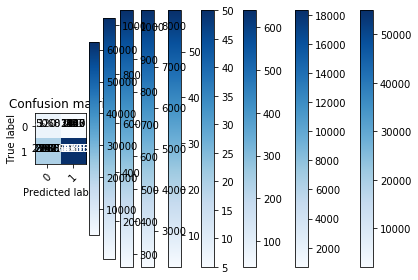

In [23]:
'''
change the name of epochs which you think it is the best to 'best_HAN_model.h5', 'best_CNN_model.h5', 'best_DNN_model.h5' for
HAN , DNN, CNN respectively
'''
if model_mode == 'test':
    model.load_weights(os.path.join(current_path, 'HAN', 'best_HAN_model.h5'))
    CNNmodel.load_weights(os.path.join(current_path, 'CNN', 'best_CNN_model.h5'))
    DNNmodel.load_weights(os.path.join(current_path, 'DNN', 'best_DNN_model.h5'))
    model.summary()
    for x_eval, y_eval in [(x_train, y_train), (x_test, y_test)]:
        print("=========== Test result in LSTM start=================")
        y = model.predict(x_eval)
        fpr, tpr, thresholds = roc_curve(y_eval, y)
        print('auc = ', auc(fpr, tpr))
        y[y > threshold_LSTM] = 1
        y[y <= threshold_LSTM] = 0
        y_pred = y.flatten()
        print(classification_report(y_eval, y_pred, target_names=target_names))
        print("accuracy = ", accuracy_score(y_eval, y_pred))
        print('AP = ', average_precision_score(y_eval, y_pred))
        cm = confusion_matrix(y_eval, y_pred)
        plot_confusion_matrix(cm, classes=['0', '1'])
        print("=========== Test result in LSTM end=================")
    DNNmodel.summary()
    for x_product_eval, y_product_eval in [(X_train_product, y_train_product), (X_val_product, y_val_product),
                                           (X_test_product, y_test_product)]:
        print("===============Test DNN================")
        y = DNNmodel.predict_classes(x_product_eval)
        fpr, tpr, thresholds = roc_curve(y_product_eval, y)
        print('auc = ', auc(fpr, tpr))
        y[y > threshold_DNN] = 1
        y[y <= threshold_DNN] = 0
        y_pred = y.flatten()
        print(classification_report(y_product_eval, y_pred, target_names=target_names))
        print("accuracy = ", accuracy_score(y_product_eval, y_pred))
        print('AP = ', average_precision_score(y_product_eval, y_pred))
        cm = confusion_matrix(y_product_eval, y_pred)
        plot_confusion_matrix(cm, classes=['0', '1'])
        print("===============Test DNN================")
    CNNmodel.summary()
    for x_reviewer_eval, y_reviewer_eval in [(X_train_reviewer, y_train_reviewer), (X_val_reviewer, y_val_reviewer),
                                             (X_test_reviewer, y_test_reviewer)]:
        print("===============Test  CNN=======")
        y = CNNmodel.predict_classes(x_reviewer_eval)
        fpr, tpr, thresholds = roc_curve(y_reviewer_eval, y)
        print('auc = ', auc(fpr, tpr))
        y[y > threshold_DNN] = 1
        y[y <= threshold_DNN] = 0
        y_pred = y.flatten()
        print(classification_report(y_reviewer_eval,
                                    y_pred, target_names=target_names))
        print("accuracy train set=", accuracy_score(y_reviewer_eval, y_pred))
        print('AP = ', average_precision_score(y_reviewer_eval, y_pred))
        cm = confusion_matrix(y_reviewer_eval, y_pred)
        plot_confusion_matrix(cm, classes=['0', '1'])
        print("===============Test  CNN=======")


    def ensemble_predictions(DNNmodel, CNNmodel, HANmodel, df):
        testX_reviewer = df[reviewer_feature_s.columns].values
        testX_product = df[product_feature_s.columns].values
        # tesX_review = encode_text(df.Text_from_ReviewContent_Sortedby_Product_wise_r.values)
        CNN_yhats = CNNmodel.predict(testX_reviewer.reshape((len(testX_reviewer), testX_reviewer.shape[1], 1)))
        DNN_yhats = DNNmodel.predict(testX_product.reshape((len(testX_product), testX_product.shape[1])))
        # HAN_yhats = HANmodel.predict(tesX_review)
        HAN_yhats = HANmodel.predict([np.concatenate((x_train[0], x_test[0]), axis=0),
                                      np.concatenate((x_train[1], x_test[1]), axis=0)])
        yhats = np.array([DNN_yhats, CNN_yhats, HAN_yhats]).squeeze()
        Soft = np.sum(yhats, axis=0)
        fpr, tpr, thresholds = roc_curve(multi_view_features.Label_Labels_for_reviews_r[:100000], Soft)
        print('auc = ', auc(fpr, tpr))
        super_threshold_indices = Soft > 1.5
        Soft[super_threshold_indices] = 1
        Soft[Soft != 1] = 0
        Hard = np.around(yhats.astype(np.float32)).astype(np.float32)
        Hard = np.sum(Hard, axis=0)
        super_threshold_indices = Hard > 1.5
        Hard[super_threshold_indices] = 1
        Hard[Hard != 1] = 0
        return Soft, Hard


    def encode_text(encoded_text):
        paras = []
        texts = []

        sent_lens = []
        sent_nums = []
        for idx in tqdm(range(len(encoded_text)), position=0, leave=True):
            # print(idx)
            text = clean_str(encoded_text[idx])
            texts.append(text)
            sentences = tokenize.sent_tokenize(text)
            sent_nums.append(len(sentences))
            for sent in sentences:
                sent_lens.append(len(text_to_word_sequence(sent)))
            paras.append(sentences)
        data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
        for i, sentences in enumerate(paras):
            for j, sent in enumerate(sentences):
                if j < max_senten_num:
                    wordTokens = text_to_word_sequence(sent)
                    k = 0
                    for _, word in enumerate(wordTokens):
                        try:
                            if k < max_senten_len and tokenizer.word_index[word] < max_features:
                                data[i, j, k] = tokenizer.word_index[word]
                                k = k + 1
                        except:
                            print(word)
                            pass
        return data


    Soft_pred, Hard_pred = ensemble_predictions(DNNmodel, CNNmodel, model, multi_view_features.iloc[:100000])
    print('final AP = ', average_precision_score(Soft_pred, multi_view_features.Label_Labels_for_reviews_r[:100000]))
    print("===================== Voting =======================")
    print("Soft voting = ", accuracy_score(multi_view_features.Label_Labels_for_reviews_r[:100000], Soft_pred))

    print("Hard voting = ", accuracy_score(multi_view_features.Label_Labels_for_reviews_r[:100000], Hard_pred))

    cm = confusion_matrix(multi_view_features.Label_Labels_for_reviews_r[:100000], Soft_pred)
    plot_confusion_matrix(cm, classes=['0', '1'])